In [2]:
# necessary imports

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
# import data from SQL Ace

from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [4]:
# import the dataset

url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
# dropping unnecessary columns

df.drop(["Channel", "Region"], axis = 1, inplace = True)
df = df.rename(columns={"Delicassen": "Deli"})

In [6]:
# Cluster on a selected subset of features

grocery_frozen_det = df[["Grocery", "Frozen", "Detergents_Paper"]]
grocery_frozen_det.head(2)

,Grocery,Frozen,Detergents_Paper
customer_id,,,
0,7561,214,2674
1,9568,1762,3293


In [7]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grocery_frozen_det)

# Use the scaler
grocery_frozen_det = scaler.transform(grocery_frozen_det)
grocery_frozen_det

array([[0.08146416, 0.0031063 , 0.0654272 ],
       [0.10309667, 0.02854842, 0.08058985],
       [0.08278992, 0.03911643, 0.08605232],
       ...,
       [0.32594285, 0.00677142, 0.36346267],
       [0.02402535, 0.01664914, 0.00404174],
       [0.02702178, 0.00065742, 0.01161082]])

In [17]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 40)

# Fit the object
dbsc.fit(grocery_frozen_det)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=40, n_jobs=None, p=None)

In [18]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Frozen", "Detergents_Paper"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_frozen_det, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Deli,Scaled_Grocery_x,Scaled_Frozen_x,Scaled_Detergents_Paper_x,labels,Scaled_Grocery_y,Scaled_Frozen_y,Scaled_Detergents_Paper_y,Scaled_Grocery,Scaled_Frozen,Scaled_Detergents_Paper
0,12669,9656,7561,214,2674,1338,0.081464,0.003106,0.065427,0,0.081464,0.003106,0.065427,0.081464,0.003106,0.065427
1,7057,9810,9568,1762,3293,1776,0.103097,0.028548,0.080590,0,0.103097,0.028548,0.080590,0.103097,0.028548,0.080590
2,6353,8808,7684,2405,3516,7844,0.082790,0.039116,0.086052,0,0.082790,0.039116,0.086052,0.082790,0.039116,0.086052
3,13265,1196,4221,6404,507,1788,0.045464,0.104842,0.012346,0,0.045464,0.104842,0.012346,0.045464,0.104842,0.012346
4,22615,5410,7198,3915,1777,5185,0.077552,0.063934,0.043455,0,0.077552,0.063934,0.043455,0.077552,0.063934,0.043455


In [19]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers

df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    412
-1     28
Name: labels, dtype: int64

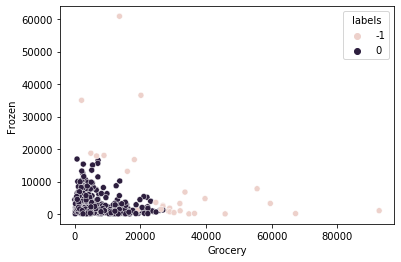

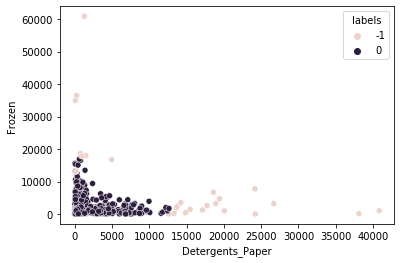

In [20]:
sns.scatterplot(df.Grocery, df.Frozen, hue=df.labels)
plt.show()

sns.scatterplot(df.Detergents_Paper, df.Frozen, hue=df.labels)
plt.show()

#### Takeaways: Some pretty extreme outliers

Text(0.5, 0, 'Grocery')

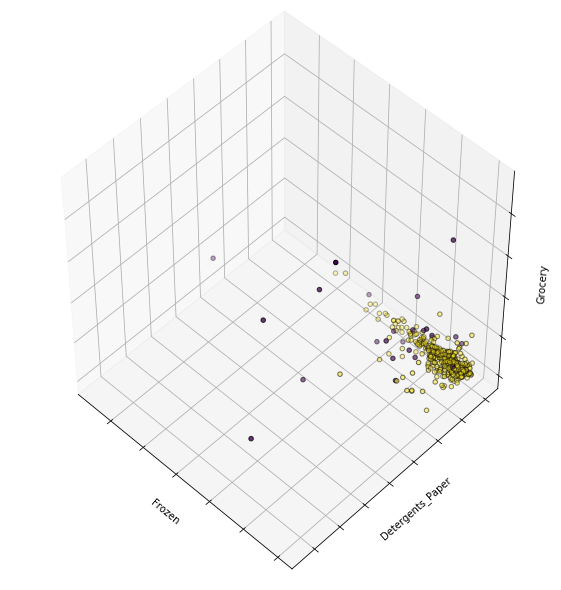

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Detergents_Paper')
ax.set_zlabel('Grocery')

#### Takeaways: looks cool, but I honestly dont know what it means

### Preparing to fumble around w the curriculum data

In [22]:
# Acquire the data and take a look

df1 = pd.read_csv('anonymized-curriculum-access.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
df1

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [25]:
# Rename the columns into something meaningful for readability

df1 = df1.rename(columns={0:'date', 
                           1:'time', 2:'path', 
                           3:'user_id',
                           4:'cohort_id', 
                           5:'ip'})

In [26]:
# Convert 'date' and 'time' into datetime and make that the index

df1.index = pd.to_datetime(df1.date + " " + df1.time)
df1

,date,time,path,user_id,cohort_id,ip
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
2021-04-21 16:41:51,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
2021-04-21 16:42:02,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
2021-04-21 16:42:09,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
2021-04-21 16:44:37,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   time       900223 non-null  object 
 2   path       900222 non-null  object 
 3   user_id    900223 non-null  int64  
 4   cohort_id  847330 non-null  float64
 5   ip         900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 48.1+ MB
